In [ ]:
# ====================================
# Notebook 8: Analyzing Checkout Time Optimization with Timestamps Order Data after Barcodes integration
# Description:
# This notebook loads logs data for three flagship stores (Umasheva, Borodinskaya, Tihaya)
# across two time periods (Q3: Jul-Sep and Q4: Oct-Dec), cleans outliers, calculates process times,
# and visualizes before/after changes for each stage of the checkout pipeline.
# ====================================

In [ ]:
import os

# === Clone GitHub repository ===
repo_dir = "My-BS-Thesis"

if os.path.exists(repo_dir):
    print(f"{repo_dir} already exists. Removing it...\n")
    !rm -r {repo_dir}

!git clone https://github.com/Goshmar/My-BS-Thesis

Cloning into 'My-BS-Thesis'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (168/168), done.
remote: Total 175 (delta 62), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (175/175), 219.58 MiB | 23.88 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
# === Install dependencies from requirements.txt ===
!pip install -r My-BS-Thesis/requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.7/557.7 MB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.2/160.2 kB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 768.5/768.5 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 39.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

In [ ]:
# === Unzip filtered order data ===
raw_data_dir = os.path.join(repo_dir, 'data', 'raw')
zip_path = os.path.join(raw_data_dir, 'timestamps_order_JulDec_2024.zip')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(raw_data_dir)

In [ ]:
# === Load filtered dataset ===
df = pd.read_csv(raw_data_dir + "/" + "orders_all.csv", parse_dates=["OrderDate", "ServiceRegistrationDate", "CompletionDate"])

In [ ]:
# === Dataset info ===
print(df.info(), end='\n\n')
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59998 entries, 0 to 59997
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   OrderDate                59998 non-null  datetime64[ns]
 1   ServiceRegistrationDate  59998 non-null  datetime64[ns]
 2   CompletionDate           59998 non-null  datetime64[ns]
 3   Manager                  59998 non-null  int64         
 4   OrderAmount              59998 non-null  int64         
 5   CustomerType             59998 non-null  object        
 6   HasExtraServices         59998 non-null  bool          
 7   MakingOrderTime          59998 non-null  int64         
 8   ServiceRegistrationTime  59998 non-null  int64         
 9   CompletionTime           59998 non-null  int64         
 10  Period                   59998 non-null  object        
 11  Store                    59998 non-null  object        
dtypes: bool(1), datetime64[ns](3), i

,OrderDate,ServiceRegistrationDate,CompletionDate,Manager,OrderAmount,CustomerType,HasExtraServices,MakingOrderTime,ServiceRegistrationTime,CompletionTime,Period,Store
55899,2024-12-07 11:01:32,2024-12-07 11:03:22,2024-12-07 11:05:14,3,6100,Individual,False,200,110,222,Q4,Tihaya
58520,2024-10-01 15:33:43,2024-10-01 15:35:45,2024-10-01 15:37:06,0,17426,Individual,True,383,122,203,Q4,Tihaya
43370,2024-09-20 13:35:13,2024-09-20 13:37:44,2024-09-20 13:38:35,3,6408,Individual,True,295,151,202,Q3,Tihaya
35984,2024-12-15 10:48:51,2024-12-15 10:50:42,2024-12-15 10:51:11,9,8967,Business,False,58,72,191,Q4,Borodinskaya
2133,2024-09-18 16:31:50,2024-09-18 16:33:35,2024-09-18 16:34:26,5,18069,Individual,True,414,201,264,Q3,Umasheva


In [ ]:
# === Delete duplicates by OrderDate and Manager ===
df.drop_duplicates(subset=["OrderDate", "Manager"], keep="first", inplace=True)
print("After delete duplicates:", df.shape[0])

After delete duplicates: 59969


In [ ]:
# === Removing outliers using QR ===
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

for col in ["MakingOrderTime", "ServiceRegistrationTime", "CompletionTime"]:
    df = remove_outliers_iqr(df, col)

print("✅ After removing outliers:", df.shape[0])

✅ After removing outliers: 59452


In [ ]:
# === Let's devide check number of orders in Q3 and Q4 ===
df["PeriodTag"] = df["OrderDate"].apply(lambda x: "Before" if x.month in [7, 8, 9] else "After")
print("Number of orders by periods:\n", df["PeriodTag"].value_counts())

Number of orders by periods:
 PeriodTag
After     29830
Before    29622
Name: count, dtype: int64


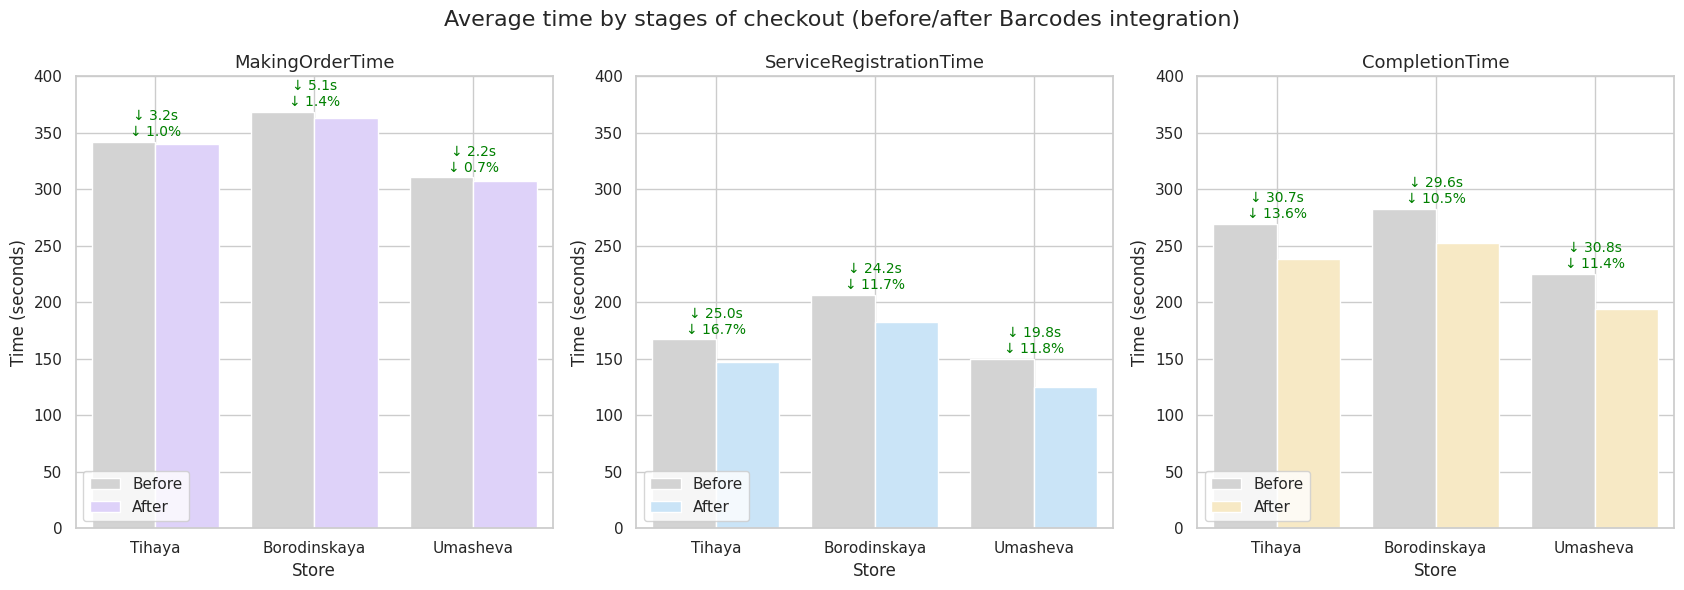

In [ ]:
# === Visualization of the three stages of checkout and their changes after the integration of barcodes ===
sns.set(style="whitegrid", palette="pastel")
fig, axes = plt.subplots(1, 3, figsize=(17, 6), sharey=False)

# Set stores, metrics, colors parameters for plots
stores = ["Umasheva", "Borodinskaya", "Tihaya"]
metrics = ["MakingOrderTime", "ServiceRegistrationTime", "CompletionTime"]
colors = {
    "MakingOrderTime": {
        "Before": "#d3d3d3",
        "After": "#dcccff"
    },
    "ServiceRegistrationTime": {
        "Before": "#d3d3d3",
        "After": "#c2e5ff"
    },
    "CompletionTime": {
        "Before": "#d3d3d3",
        "After": "#ffecbd"
    }
}

# Draw three stages of checkout and their changes
for i, metric in enumerate(metrics):
    palette = colors[metric]

    # Create barplot with mean estimator and no error bars
    sns.barplot(
        data=df,
        x="Store", y=metric, hue="PeriodTag",
        estimator=np.mean, errorbar=None, ax=axes[i],
        palette=palette
    )

    axes[i].set_title(f"{metric}", fontsize=13)
    axes[i].set_xlabel("Store")
    axes[i].set_ylabel("Time (seconds)")
    axes[i].set_ylim(0, 400)
    axes[i].grid(True)

    handles, labels = axes[i].get_legend_handles_labels()
    axes[i].legend(handles, labels, loc="lower left", bbox_to_anchor=(0, 0))

    # === Annotate each store's change above the taller bar ===
    patches = axes[i].patches  # all bar rectangles
    for j, store in enumerate(stores):
        x_before = j - 0.2
        x_after = j + 0.2
        x_center = j

        # Find corresponding bars and their heights
        bar_before = next((p for p in patches if abs(p.get_x() + p.get_width()/2 - x_before) < 0.01), None)
        bar_after = next((p for p in patches if abs(p.get_x() + p.get_width()/2 - x_after) < 0.01), None)

        h_before = bar_before.get_height() if bar_before else 0
        h_after = bar_after.get_height() if bar_after else 0
        y_pos = max(h_before, h_after) + 5  # position text above taller bar

        # Calculate deltas for annotation
        mean_before = df[(df["Store"] == store) & (df["PeriodTag"] == "Before")][metric].mean()
        mean_after = df[(df["Store"] == store) & (df["PeriodTag"] == "After")][metric].mean()
        diff = mean_before - mean_after
        pct = diff / mean_before * 100

        # Add green annotation above the bars
        axes[i].text(
            x_center, y_pos,
            f"↓ {diff:.1f}s\n↓ {pct:.1f}%",
            ha="center", color="green", fontsize=10
        )

# Set a common title
fig.suptitle("Average time by stages of checkout (before/after Barcodes integration)", fontsize=16)
plt.tight_layout()
plt.show()

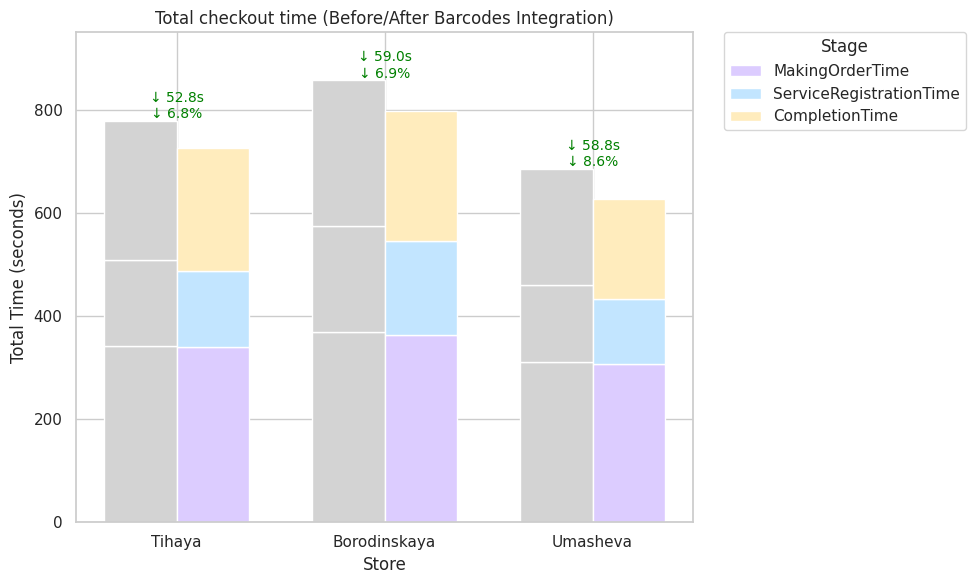

In [ ]:
# === Visualization Total checkout time and changes after the integration of barcodes ===

# Compute average stage durations grouped by store and period
grouped = df.groupby(["Store", "PeriodTag"])[["MakingOrderTime", "ServiceRegistrationTime", "CompletionTime"]].mean().reset_index()

# Convert to long format for plotting
df_melted = pd.melt(
    grouped,
    id_vars=["Store", "PeriodTag"],
    value_vars=["MakingOrderTime", "ServiceRegistrationTime", "CompletionTime"],
    var_name="Stage",
    value_name="Time"
)

# Define stage order and custom colors
stage_order = ["MakingOrderTime", "ServiceRegistrationTime", "CompletionTime"]
after_colors = {
    "MakingOrderTime": "#dcccff",         # light violet
    "ServiceRegistrationTime": "#c2e5ff", # light blue
    "CompletionTime": "#ffecbd"           # light yellow
}
gray = "#d3d3d3"  # color for 'Before' bars

# Set draw parameters
fig, ax = plt.subplots(figsize=(10, 6))
stores = df["Store"].unique()
periods = ["Before", "After"]
bar_width = 0.35
x = np.arange(len(stores))

# Track bar stacking positions
bottoms = {
    "Before": np.zeros(len(stores)),
    "After": np.zeros(len(stores))
}

# Track final stacked heights for annotation
total_before = np.zeros(len(stores))
total_after = np.zeros(len(stores))

# Draw stacked bars per stage and period
for stage in stage_order:
    for i, period in enumerate(periods):
        subset = df_melted[(df_melted["Stage"] == stage) & (df_melted["PeriodTag"] == period)]
        heights = []
        for store in stores:
            val = subset[subset["Store"] == store]["Time"]
            heights.append(val.values[0] if not val.empty else 0)

        offset = -bar_width / 2 if period == "Before" else bar_width / 2
        color = gray if period == "Before" else after_colors[stage]

        bars = ax.bar(
            x + offset,
            height=heights,
            width=bar_width,
            bottom=bottoms[period],
            color=color,
            label=stage if period == "After" else None
        )

        bottoms[period] += heights

        # Save total stacked height for annotation after final stage
        if stage == "CompletionTime":
            total_before = bottoms["Before"]
            total_after = bottoms["After"]

# Add change annotations above taller stacked bars
for i, store in enumerate(stores):
    diff = total_before[i] - total_after[i]
    pct = diff / total_before[i] * 100
    y_pos = max(total_before[i], total_after[i]) + 5

    ax.text(
        x[i], y_pos,
        f"↓ {diff:.1f}s\n↓ {pct:.1f}%",
        ha="center", fontsize=10, color="green"
    )

# Final plot formatting
ax.set_xticks(x)
ax.set_xticklabels(stores)
ax.set_ylabel("Total Time (seconds)")
ax.set_xlabel("Store")
ax.set_title("Total checkout time (Before/After Barcodes Integration)")
ax.set_ylim(0, 950)

# Add legend outside the plot area
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(
    by_label.values(), by_label.keys(),
    title="Stage",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.
)

ax.grid(True, axis="y")
plt.tight_layout()
plt.show()
